In [1]:
# import libraries
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from os import path
from glob import glob
from tqdm import tqdm

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from tensorflow import keras 

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)

def model_performance_plot(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
  
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],label = 'Validation Accuracy')
    plt.legend()
#     plt.savefig('../images/model_accuracy.png')
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.title('Training and Validation Binary Crossentropy Loss')
    plt.plot(hist['epoch'], hist['loss'],label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
#     plt.savefig('../images/model_loss.png')
    plt.show()

In [3]:
# create directory paths for images (from dataset)
base_dir = '../../overview/project_data/COMPLETE_DATASET'
train_dir = path.join(base_dir, 'TRAIN')
test_dir = path.join(base_dir, 'TEST')

print(train_dir)
print(test_dir)

../../overview/project_data/COMPLETE_DATASET/TRAIN
../../overview/project_data/COMPLETE_DATASET/TEST


# IMAGE PREPROCESSING

In [4]:
img_height = 256
img_width = 256
batch_size = 32

In [5]:
# image scaling
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0,
                                   validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

In [6]:
# initialize train, validation, testing generator
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42)

valid_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True,
    seed=42)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    seed=42)

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [7]:
earlystopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=0.005,
                              patience=5,
                              mode='max',
                              verbose=1)

checkpoint = ModelCheckpoint(filepath='./checkpoint/',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

callbacks = [earlystopping, checkpoint]

# SIMPLE NEURAL NET

In [8]:
model1 = Sequential()

model1.add(Flatten(input_shape=(256,256,3)))
model1.add(Dense(units=20, activation='relu'))
model1.add(Dense(units=10, activation='relu'))
model1.add(Dense(units=1, activation='sigmoid'))

model1.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 20)                3932180   
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3,932,401
Trainable params: 3,932,401
Non-trainable params: 0
_________________________________________________________________


2022-09-07 22:07:40.252309: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
simple_neural_net = model1.fit(train_generator,
                               epochs=20,
                               validation_data=valid_generator,
                               callbacks=callbacks)

Epoch 1/20
565/565 [==============================] - ETA: 0s - loss: 1.0315 - accuracy: 0.7145
Epoch 1: val_accuracy improved from -inf to 0.78879, saving model to ./checkpoint/
INFO:tensorflow:Assets written to: ./checkpoint/assets
565/565 [==============================] - 47s 83ms/step - loss: 1.0315 - accuracy: 0.7145 - val_loss: 0.6208 - val_accuracy: 0.7888
Epoch 2/20
565/565 [==============================] - ETA: 0s - loss: 0.8583 - accuracy: 0.7396
Epoch 2: val_accuracy did not improve from 0.78879
565/565 [==============================] - 42s 73ms/step - loss: 0.8583 - accuracy: 0.7396 - val_loss: 0.5509 - val_accuracy: 0.7795
Epoch 3/20
565/565 [==============================] - ETA: 0s - loss: 0.6647 - accuracy: 0.7526
Epoch 3: val_accuracy did not improve from 0.78879
565/565 [==============================] - 42s 75ms/step - loss: 0.6647 - accuracy: 0.7526 - val_loss: 0.8558 - val_accuracy: 0.6591
Epoch 4/20
565/565 [==============================] - ETA: 0s - loss: 0.7

In [10]:
# evaluate model
neural_net_loss, neural_net_accuracy = model1.evaluate(test_generator)
print(f"Test Accuracy: {neural_net_accuracy:.4f}")
print(f"Test Loss: {neural_net_loss:.4f}")

79/79 [==============================] - 5s 64ms/step - loss: 0.3879 - accuracy: 0.8567
Test Accuracy: 0.8567
Test Loss: 0.3879


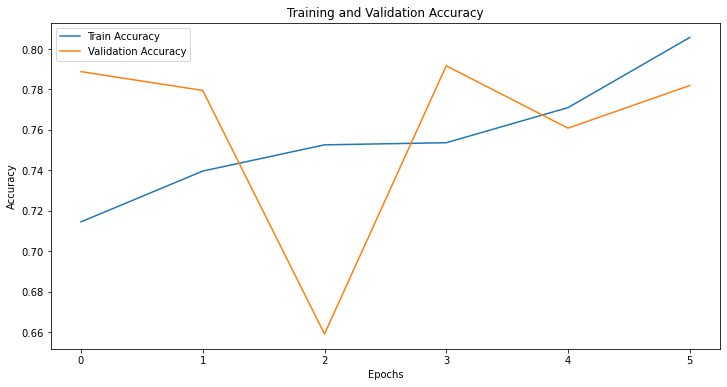

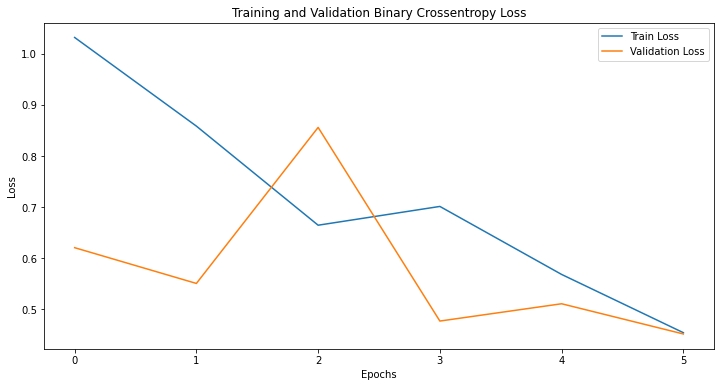

In [11]:
# plot model performance
model_performance_plot(simple_neural_net)

# SIMPLE CNN

In [12]:
model2 = Sequential()

model2.add(InputLayer(input_shape=(256,256,3)))

model2.add(Conv2D(filters=16,kernel_size=3,activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
    
model2.add(Flatten())
    
model2.add(Dense(16, activation='relu'))
    
model2.add(Dense(1, activation='sigmoid'))
    
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 258064)            0         
                                                                 
 dense_3 (Dense)             (None, 16)                4129040   
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,129,505
Trainable params: 4,129,505
Non-trainable params: 0
____________________________________________

In [13]:
simple_cnn = model2.fit(train_generator,
                        epochs=20,
                        validation_data=valid_generator,
                        callbacks=callbacks)

Epoch 1/20
565/565 [==============================] - ETA: 0s - loss: 0.7553 - accuracy: 0.5561
Epoch 1: val_accuracy did not improve from 0.79167
565/565 [==============================] - 214s 378ms/step - loss: 0.7553 - accuracy: 0.5561 - val_loss: 0.6874 - val_accuracy: 0.5570
Epoch 2/20
565/565 [==============================] - ETA: 0s - loss: 0.6869 - accuracy: 0.5568
Epoch 2: val_accuracy did not improve from 0.79167
565/565 [==============================] - 212s 374ms/step - loss: 0.6869 - accuracy: 0.5568 - val_loss: 0.6867 - val_accuracy: 0.5570
Epoch 3/20
565/565 [==============================] - ETA: 0s - loss: 0.6867 - accuracy: 0.5568
Epoch 3: val_accuracy did not improve from 0.79167
565/565 [==============================] - 203s 359ms/step - loss: 0.6867 - accuracy: 0.5568 - val_loss: 0.6867 - val_accuracy: 0.5570
Epoch 4/20
565/565 [==============================] - ETA: 0s - loss: 0.6867 - accuracy: 0.5568
Epoch 4: val_accuracy did not improve from 0.79167
565/565

In [14]:
# evaluate model
simple_loss, simple_accuracy = model2.evaluate(test_generator)
print(f"Test Accuracy: {simple_accuracy:.4f}")
print(f"Test Loss: {simple_loss:.4f}")

79/79 [==============================] - 8s 96ms/step - loss: 0.6865 - accuracy: 0.5575
Test Accuracy: 0.5575
Test Loss: 0.6865


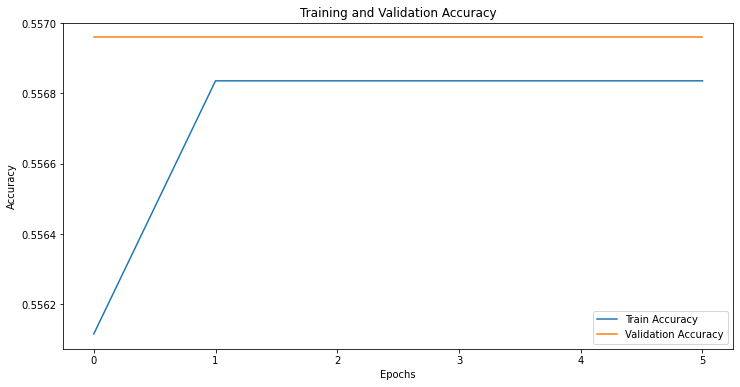

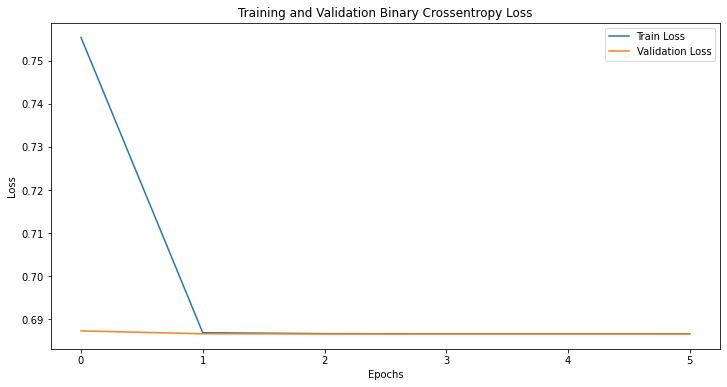

In [15]:
model_performance_plot(simple_cnn)